## Comprehensive Genotype Quality Control Analysis

####  Analysis of genotype data comparing reference HapMap data with laboratory results. 

In [16]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import itertools

In [2]:
REFERENCE_DIR = "../"
LAB_FILE = "../genotype_inf.txt"

## Load Data

In [3]:
def load_reference_data(reference_dir):
    """Load all HapMap reference files."""
    print("Loading reference data...")
    pattern = os.path.join(reference_dir, "HapMap_r23a_CEP_C*_AllSNPs.txt")
    files = glob.glob(pattern)
    
    if not files:
        raise FileNotFoundError(f"No reference files found in {reference_dir}")
    
    dfs = []
    for file_path in files:
        df = pd.read_csv(file_path, sep='\t', header=None,
                        names=['individual', 'marker', 'allele_result'])
        dfs.append(df)
    
    combined = pd.concat(dfs, ignore_index=True)
    
    # Strip whitespace
    for col in combined.columns:
        combined[col] = combined[col].str.strip()
    
    print(f"Loaded {len(combined):,} reference records from {len(files)} files")
    return combined

def load_lab_data(lab_file):
    """Load lab genotype data."""
    print("Loading lab data...")
    if not os.path.exists(lab_file):
        raise FileNotFoundError(f"Lab file not found: {lab_file}")
    
    df = pd.read_csv(lab_file, sep=';', skiprows=2,
                     names=['individual', 'marker', 'allele_result'])
    
    # Strip whitespace
    for col in df.columns:
        df[col] = df[col].str.strip()
    
    print(f"Loaded {len(df):,} lab records")
    return df

In [6]:
# Load data
ref_df = load_reference_data(REFERENCE_DIR)
lab_df = load_lab_data(LAB_FILE)

print("\n" + "="*60)
print("INITIAL DATA EXAMINATION")
print("="*60)

print(f"\nReference Data Shape: {ref_df.shape}")
print(f"Lab Data Shape: {lab_df.shape}")

print("\nReference Data Sample:")
display(ref_df.head())

print("\nLab Data Sample:")
display(lab_df.head())


Loading reference data...
Loaded 240,000 reference records from 6 files
Loading lab data...
Loaded 240,000 lab records

INITIAL DATA EXAMINATION

Reference Data Shape: (240000, 3)
Lab Data Shape: (240000, 3)

Reference Data Sample:


,individual,marker,allele_result
0,CEP_C1,rs10399749,C/C
1,CEP_C1,rs4030303,C/C
2,CEP_C1,rs4030300,G/G
3,CEP_C1,rs940550,T/T
4,CEP_C1,rs13328714,C/C



Lab Data Sample:


,individual,marker,allele_result
0,CEP_C13,rs17195431,G/G
1,CEP_C14,rs88780942,C/G
2,CEP_C1,rs29504795,G/G
3,CEP_C16,rs4531439,C/C
4,CEP_C15,rs5030461,A/A


## DATA STRUCTURE ANALYSIS

### Reference

In [69]:
# Reference data analysis
ref_individuals = set(ref_df['individual'].unique())
ref_markers = set(ref_df['marker'].unique())
ref_combinations = set(zip(ref_df['individual'], ref_df['marker']))

print(f"\nReference Data:")
print(f"  • Total rows: {len(ref_df):,}")
print(f"  • Unique individuals: {len(ref_individuals)}")
print(f"  • Possible Individual-marker combinations: {len(ref_combinations):,}")
print(f"  • Unique markers: {len(ref_markers):,}")
print(f"  • Individual-marker combinations: {set(itertools.islice(ref_combinations, 3))}")
print(f"  • Individuals: {sorted(ref_individuals)}")


Reference Data:
  • Total rows: 240,000
  • Unique individuals: 6
  • Possible Individual-marker combinations: 240,000
  • Unique markers: 40,001
  • Individual-marker combinations: {('CEP_C13', 'rs2616379'), ('CEP_C15', 'rs11827033'), ('CEP_C13', 'rs2053669')}
  • Individuals: ['CEP_C1', 'CEP_C13', 'CEP_C14', 'CEP_C15', 'CEP_C16', 'CEP_C2']


### Lab Data

In [73]:
# Lab data analysis
lab_individuals = set(lab_df['individual'].unique())
lab_markers = set(lab_df['marker'].unique())
lab_combinations = set(zip(lab_df['individual'], lab_df['marker']))

print(f"\nLab Data:")
print(f"  • Total rows: {len(lab_df):,}")
print(f"  • Unique individuals: {len(lab_individuals)}")
print(f"  • Unique markers: {len(lab_markers):,}")
print(f"  • Individual-marker combinations: {len(lab_combinations):,} Ideal: {len(lab_individuals)*len(lab_markers)}")
print(f"  • Individuals: {sorted(lab_individuals)}")



Lab Data:
  • Total rows: 240,000
  • Unique individuals: 6
  • Unique markers: 136,056
  • Individual-marker combinations: 239,973 Ideal: 816336
  • Individuals: ['CEP_C1', 'CEP_C13', 'CEP_C14', 'CEP_C15', 'CEP_C16', 'CEP_C2']


#### NOTE:
There are Unique markers: 136,056 in lb data but 40,001 in Ref.

In [53]:
# Markers per individual in lab data
individual_counts = lab_df['individual'].value_counts()
print(f"Individuals counts: \n{individual_counts}")

Individuals counts: 
individual
CEP_C16    40166
CEP_C14    40165
CEP_C13    40032
CEP_C15    39994
CEP_C1     39903
CEP_C2     39740
Name: count, dtype: int64


Markers per individual in lab data:
  • CEP_C1: 39,903 markers
  • CEP_C13: 40,032 markers
  • CEP_C14: 40,165 markers
  • CEP_C15: 39,994 markers
  • CEP_C16: 40,166 markers
  • CEP_C2: 39,740 markers


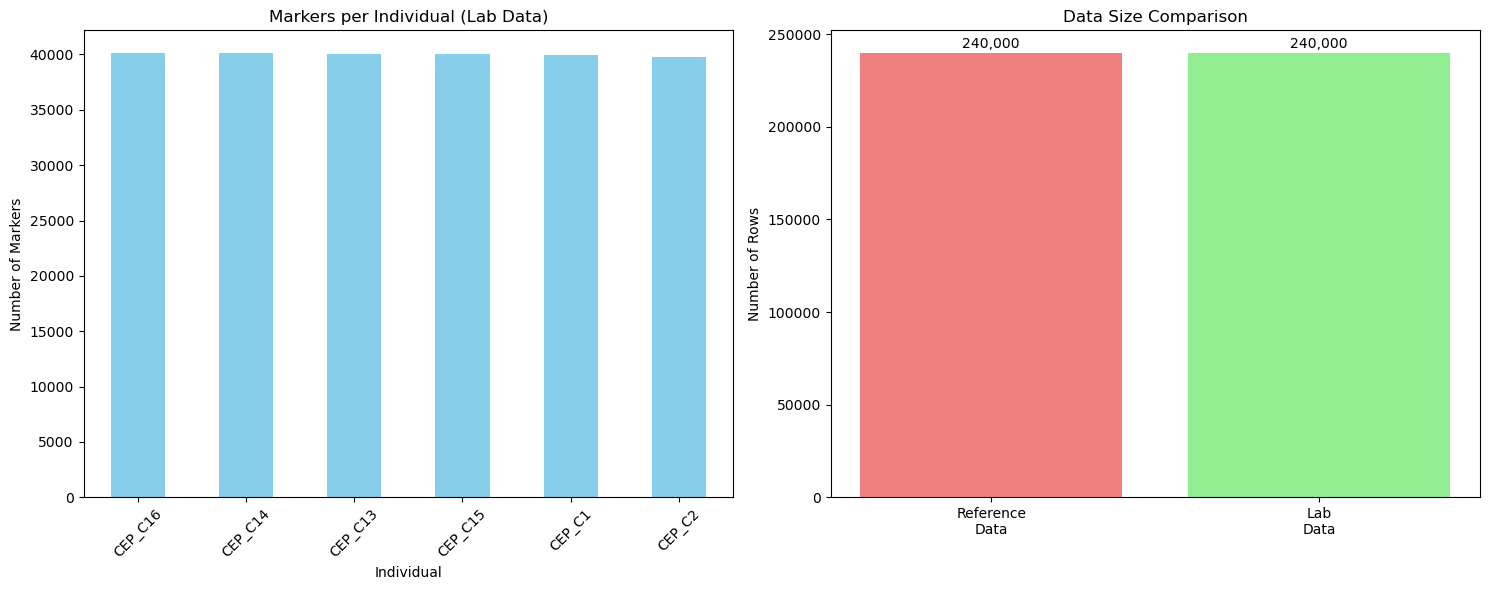

In [54]:
print(f"Markers per individual in lab data:")
for ind in sorted(lab_individuals):
    count = individual_counts[ind]
    print(f"  • {ind}: {count:,} markers")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Markers per individual
individual_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Markers per Individual (Lab Data)')
ax1.set_xlabel('Individual')
ax1.set_ylabel('Number of Markers')
ax1.tick_params(axis='x', rotation=45)

# Data size comparison
categories = ['Reference\nData', 'Lab\nData']
sizes = [len(ref_df), len(lab_df)]
colors = ['lightcoral', 'lightgreen']

ax2.bar(categories, sizes, color=colors)
ax2.set_title('Data Size Comparison')
ax2.set_ylabel('Number of Rows')

# Add value labels on bars
for i, v in enumerate(sizes):
    ax2.text(i, v + 1000, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Check marker consistency in reference among individuals

In [55]:
#    Check if all individuals in reference data have the same marker sets.
print("CHECKING MARKER CONSISTENCY IN REFERENCE DATA")
print("="*60)

# Get markers per individual
marker_sets = {}
individual_counts = {}

print(f"\nMarker Count Summary:")    
for individual in ref_df['individual'].unique():
    individual_markers = set(ref_df[ref_df['individual'] == individual]['marker'])
    marker_sets[individual] = individual_markers            #dict: key individual; val:set(markers)
    individual_counts[individual] = len(individual_markers) #dict: key individual; val:len(set(markers))
    print(f"{individual}: {len(individual_markers):,} markers")
    
# Check consistency
print(f"\nMARKER CONSISTENCY CHECK:")
all_markers_same = True
reference_markers = None
inconsistencies = {}

#loop thru marker_set dict.
for individual, markers in marker_sets.items():
    if reference_markers is None:
        reference_markers = markers
        print(f"  Using {individual} as reference: {len(markers):,} markers")
    else:
        if markers == reference_markers:
            print(f"{individual}: SAME markers as reference")
        else:
            print(f"{individual}: DIFFERENT markers from reference")
            all_markers_same = False
            
            # Find differences
            only_in_ref = reference_markers - markers
            only_in_individual = markers - reference_markers
            
            inconsistencies[individual] = {
                'missing': only_in_ref,
                'extra': only_in_individual
            }
            
            if only_in_ref:
                print(f"    Missing in {individual}: {len(only_in_ref)} markers")
                print(f"    Examples: {list(only_in_ref)[:5]}")
            if only_in_individual:
                print(f"    Extra in {individual}: {len(only_in_individual)} markers")
                print(f"    Examples: {list(only_in_individual)[:5]}")

if all_markers_same:
    print("All individuals have IDENTICAL marker sets")
    print("Reference data is consistent across individuals")
else:
    print("Individuals have DIFFERENT marker sets")
    print("Reference data has inconsistencies")

CHECKING MARKER CONSISTENCY IN REFERENCE DATA

Marker Count Summary:
CEP_C1: 40,000 markers
CEP_C14: 40,000 markers
CEP_C2: 40,000 markers
CEP_C13: 40,000 markers
CEP_C15: 40,000 markers
CEP_C16: 40,000 markers

MARKER CONSISTENCY CHECK:
  Using CEP_C1 as reference: 40,000 markers
CEP_C14: DIFFERENT markers from reference
    Missing in CEP_C14: 1 markers
    Examples: ['rs10838923']
    Extra in CEP_C14: 1 markers
    Examples: ['rs12099259']
CEP_C2: SAME markers as reference
CEP_C13: DIFFERENT markers from reference
    Missing in CEP_C13: 1 markers
    Examples: ['rs10838923']
    Extra in CEP_C13: 1 markers
    Examples: ['rs12099259']
CEP_C15: DIFFERENT markers from reference
    Missing in CEP_C15: 1 markers
    Examples: ['rs10838923']
    Extra in CEP_C15: 1 markers
    Examples: ['rs12099259']
CEP_C16: DIFFERENT markers from reference
    Missing in CEP_C16: 1 markers
    Examples: ['rs10838923']
    Extra in CEP_C16: 1 markers
    Examples: ['rs12099259']
Individuals have DIF

## Marker overlap between Ref and Lab

In [64]:
# Marker overlap
print(f"  • Ref unique markers: {len(ref_markers):,}")
print(f"  • Lab unique markers: {len(lab_markers):,}")

  • Ref unique markers: 40,001
  • Lab unique markers: 136,056


In [66]:
common_markers = ref_markers & lab_markers
ref_only_markers = ref_markers - lab_markers
lab_only_markers = lab_markers - ref_markers

print(f"  • Common markers: {len(common_markers):,}")
print(f"  • Reference-only markers, Markers unoq to Ref: {len(ref_only_markers):,}")
print(f"  • Lab-only markers, Markers unoq to Lab: {len(lab_only_markers):,}")
print(f"  • Total unique markers: {len(ref_markers | lab_markers):,}")
print(f"  • Overlap percentage: {len(common_markers)/len(ref_markers | lab_markers)*100:.1f}%")

  • Common markers: 39,834
  • Reference-only markers, Markers unoq to Ref: 167
  • Lab-only markers, Markers unoq to Lab: 96,222
  • Total unique markers: 136,223
  • Overlap percentage: 29.2%


In [75]:
# Combination overlap
common_combinations = ref_combinations & lab_combinations
ref_only_combinations = ref_combinations - lab_combinations
lab_only_combinations = lab_combinations - ref_combinations

print(f"\nIndividual-Marker Combination Overlap:")
print(f"  • Common combinations: {len(common_combinations):,}")
print(f"  • Reference-only combinations: {len(ref_only_combinations):,}")
print(f"  • Lab-only combinations: {len(lab_only_combinations):,}")


Individual-Marker Combination Overlap:
  • Common combinations: 143,720
  • Reference-only combinations: 96,280
  • Lab-only combinations: 96,253


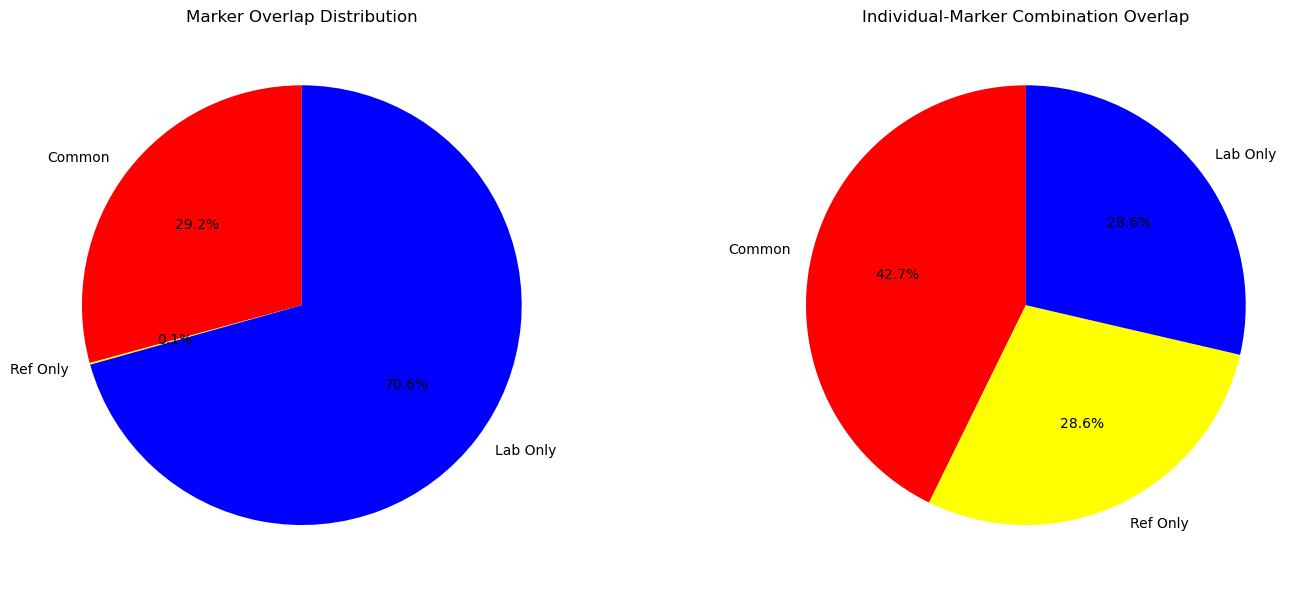

In [76]:
# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Marker overlap
marker_data = [len(common_markers), len(ref_only_markers), len(lab_only_markers)]
marker_labels = ['Common', 'Ref Only', 'Lab Only']
colors = ['red', 'yellow', 'blue']

ax1.pie(marker_data, labels=marker_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Marker Overlap Distribution')

# Combination overlap
combo_data = [len(common_combinations), len(ref_only_combinations), len(lab_only_combinations)]
combo_labels = ['Common', 'Ref Only', 'Lab Only']

ax2.pie(combo_data, labels=combo_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Individual-Marker Combination Overlap')

plt.tight_layout()
plt.show()

## Check for Missing Values

In [92]:
ref_df.isna().sum()

individual          0
marker              0
allele_result    3854
dtype: int64

In [93]:
lab_df.isna().sum()

individual          0
marker              0
allele_result    3836
dtype: int64

In [77]:
# Check null values in original data
ref_nulls = ref_df['allele_result'].isna().sum()
lab_nulls = lab_df['allele_result'].isna().sum()

print(f"Data Null Values:")
print(f"  • Reference data nulls: {ref_nulls:,}")
print(f"  • Lab data nulls: {lab_nulls:,}")

Data Null Values:
  • Reference data nulls: 3,854
  • Lab data nulls: 3,836


In [81]:
# Remove null values
ref_clean = ref_df.dropna(subset=['allele_result'])
lab_clean = lab_df.dropna(subset=['allele_result'])

print(f"\nAfter Null Removal:")
print(f"  • Reference data has: {len(ref_clean):,} rows (removed {len(ref_df) - len(ref_clean):,} nulls)")
print(f"  • Lab data has: {len(lab_clean):,} rows (removed {len(lab_df) - len(lab_clean):,} nulls)")



After Null Removal:
  • Reference data has: 236,146 rows (removed 3,854 nulls)
  • Lab data has: 236,164 rows (removed 3,836 nulls)


In [85]:
# Clean set of markers 
ref_markers_clean = set(ref_clean['marker'])
lab_markers_clean = set(lab_clean['marker'])

common_markers_clean = ref_markers_clean & lab_markers_clean
ref_only_markers_clean = ref_markers_clean - lab_markers_clean
lab_only_markers_clean = lab_markers_clean - ref_markers_clean

print(f"\nClean Data Marker Overlap:")
print(f"  • Common markers: {len(common_markers_clean):,}")
print(f"  • Reference-only markers, Markers unoq to Ref: {len(ref_only_markers_clean):,}")
print(f"  • Lab-only markers, Markers unoq to Lab: {len(lab_only_markers_clean):,}")
print(f"  • Overlap percentage: {len(common_markers_clean)/len(ref_markers_clean | lab_markers_clean)*100:.1f}%")


Clean Data Marker Overlap:
  • Common markers: 39,801
  • Reference-only markers, Markers unoq to Ref: 200
  • Lab-only markers, Markers unoq to Lab: 94,642
  • Overlap percentage: 29.6%


In [86]:
# INDIVIDUAL-MARKER COMBINATION ANALYSIS
ref_combinations_clean = set(zip(ref_clean['individual'], ref_clean['marker']))
lab_combinations_clean = set(zip(lab_clean['individual'], lab_clean['marker']))

common_combinations_clean = ref_combinations_clean & lab_combinations_clean
ref_only_combinations_clean = ref_combinations_clean - lab_combinations_clean
lab_only_combinations_clean = lab_combinations_clean - ref_combinations_clean

print(f"\nClean Data Individual-Marker Combinations:")
print(f"  • Common combinations: {len(common_combinations_clean):,}")
print(f"  • Reference-only combinations: {len(ref_only_combinations_clean):,}")
print(f"  • Lab-only combinations: {len(lab_only_combinations_clean):,}")


Clean Data Individual-Marker Combinations:
  • Common combinations: 141,445
  • Reference-only combinations: 94,701
  • Lab-only combinations: 94,692


In [90]:
# Compare with original analysis
print(f"\nComparison with Clean vs Original Analysis:")
print(f"  • Common markers: {len(common_markers_clean):,} vs {len(common_markers):,}")
print(f"  • Common combinations: {len(common_combinations_clean):,} vs {len(common_combinations):,}")
# print(f"  • Marker overlap %: {len(common_markers_clean)/len(ref_markers_clean | lab_markers_clean)*100:.1f}% vs {len(common_markers)/len(ref_markers | lab_markers)*100:.1f}%")



Comparison with Clean vs Original Analysis:
  • Common markers: 39,801 vs 39,834
  • Common combinations: 141,445 vs 143,720


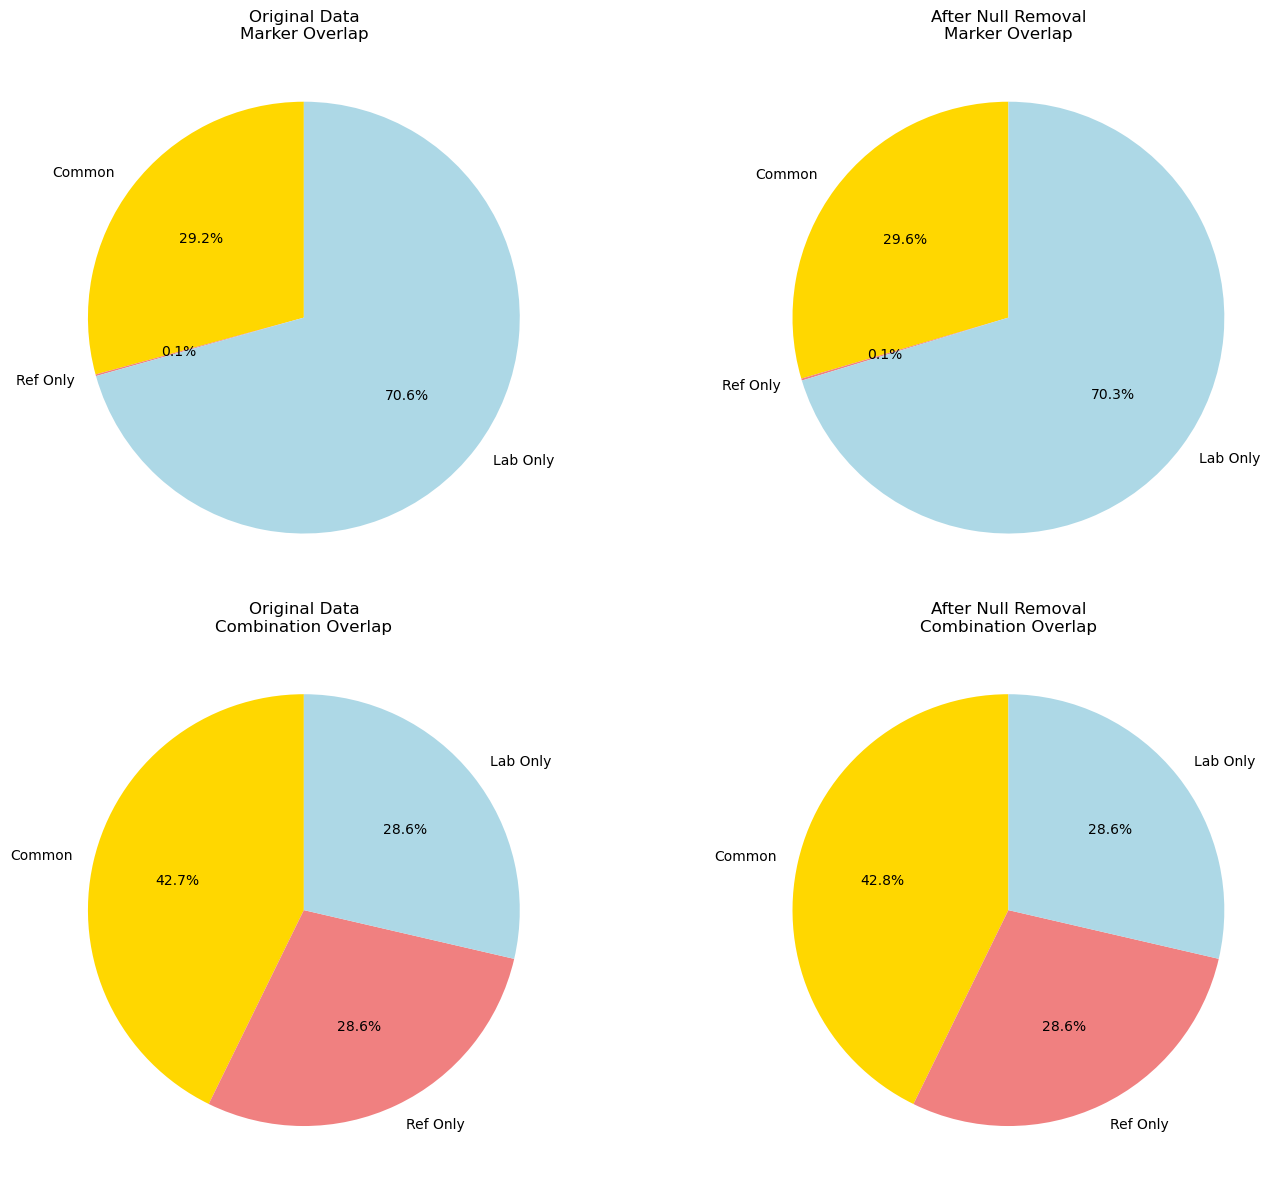

In [91]:
# Create comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original marker overlap
marker_data_orig = [len(common_markers), len(ref_only_markers), len(lab_only_markers)]
marker_labels = ['Common', 'Ref Only', 'Lab Only']
colors = ['gold', 'lightcoral', 'lightblue']

ax1.pie(marker_data_orig, labels=marker_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Original Data\nMarker Overlap')

# Clean marker overlap
marker_data_clean = [len(common_markers_clean), len(ref_only_markers_clean), len(lab_only_markers_clean)]
ax2.pie(marker_data_clean, labels=marker_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('After Null Removal\nMarker Overlap')

# Original combinations
combo_data_orig = [len(common_combinations), len(ref_only_combinations), len(lab_only_combinations)]
ax3.pie(combo_data_orig, labels=marker_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax3.set_title('Original Data\nCombination Overlap')

# Clean combinations
combo_data_clean = [len(common_combinations_clean), len(ref_only_combinations_clean), len(lab_only_combinations_clean)]
ax4.pie(combo_data_clean, labels=marker_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax4.set_title('After Null Removal\nCombination Overlap')

plt.tight_layout()
plt.show()

### NOTE: Lab has more markers but less overlap with Ref. 

# MERGE

In [96]:
merged = pd.merge(ref_clean, lab_clean,
                             on=['individual', 'marker'],
                             how='outer',
                             indicator='status',
                             suffixes=('_ref', '_lab'))
merged['status'] = merged['status'].map({
    'both': 'Common',
    'left_only': 'Ref_Only',
    'right_only': 'Lab_Only'
    })
merged.sample(n=10)

,individual,marker,allele_result_ref,allele_result_lab,status
252578,CEP_C16,rs3817442,C/T,C/T,Common
279516,CEP_C2,rs10837423,C/C,NaN,Ref_Only
315489,CEP_C2,rs607165,G/G,NaN,Ref_Only
325952,CEP_C2,rs79649775,NaN,A/A,Lab_Only
266763,CEP_C16,rs73665767,NaN,G/G,Lab_Only
257931,CEP_C16,rs5024633,A/A,A/A,Common
75425,CEP_C13,rs16918483,A/A,A/A,Common
174441,CEP_C15,rs11039410,A/A,A/A,Common
200073,CEP_C15,rs45389400,NaN,A/A,Lab_Only
45020,CEP_C1,rs7128520,C/C,NaN,Ref_Only


In [119]:
common_df = merged[merged['status'] == 'Common']
common_df.head()

,individual,marker,allele_result_ref,allele_result_lab,status
0,CEP_C1,rs1000186,C/T,C/T,Common
1,CEP_C1,rs1000343,C/C,C/C,Common
2,CEP_C1,rs1000447,C/C,C/C,Common
4,CEP_C1,rs1000540,T/T,T/T,Common
7,CEP_C1,rs1000677,T/T,T/T,Common


### Match allele result

In [121]:
common_df.loc[:,'match'] = common_df['allele_result_ref'] == common_df['allele_result_lab']
common_df.sample(n=2)

,individual,marker,allele_result_ref,allele_result_lab,status,match
103194,CEP_C13,rs7931439,A/A,A/A,Common,True
277819,CEP_C2,rs10767810,C/T,C/T,Common,True


In [123]:
matches = common_df[common_df['match']]
mismatches=common_df[~common_df['match']]
mismatch.sample(10)

,individual,marker,allele_result_ref,allele_result_lab,status,match
228548,CEP_C16,rs11037041,A/G,T/A,Common,False
285203,CEP_C2,rs11490925,G/G,A/C,Common,False
222029,CEP_C16,rs10742620,G/G,C/A,Common,False
185090,CEP_C15,rs1570216,A/A,G/T,Common,False
111789,CEP_C14,rs10742825,G/G,T/T,Common,False
235578,CEP_C16,rs12420694,T/T,C/C,Common,False
254446,CEP_C16,rs4348886,C/C,T/T,Common,False
154611,CEP_C14,rs7119404,C/T,C/G,Common,False
170575,CEP_C15,rs11029849,G/G,C/G,Common,False
242170,CEP_C16,rs16938126,C/G,G/C,Common,False


# STATS:

In [129]:
total_comparisons = len(common_df)
total_mismatches = len(mismatches)
total_matches = len(matches)
error_rate = (total_mismatches / total_comparisons) * 100

print("COMPREHENSIVE STATISTICS:")
print(f"  • Total comparisons (common): {total_comparisons:,}")
print(f"  • Matches: {total_matches:,} ({total_matches/total_comparisons*100:.1f}%)")
print(f"  • Mismatches: {total_mismatches:,} (Error: {error_rate:.2f}%)")

COMPREHENSIVE STATISTICS:
  • Total comparisons (common): 141,459
  • Matches: 140,048 (99.0%)
  • Mismatches: 1,411 (Error: 1.00%)


In [130]:
unique_error_markers = mismatches['marker'].nunique()
print(f"  • Unique error markers: {unique_error_markers:,}")

  • Unique error markers: 1,389


In [132]:
unique_error_markers_list = sorted(mismatches['marker'].unique())
for marker in unique_error_markers_list[:10]:
    print(f"{marker}")

rs1000480
rs1003715
rs1008041
rs10082678
rs1009070
rs1013608
rs10160324
rs10160379
rs1016747
rs1020281
